In [1]:
import torch
import data
import tqdm
import models
import numpy as np
from torchvision.transforms.functional import affine
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
EPOCHS = 200
BATCH_SIZE = 10
LR = 5e-7

In [3]:
def transform(image, degrees, scale):
    return affine(image, angle=degrees,translate=[0,0],scale=scale,shear=[0,0])

def show_random_image(dataset, model, length):
    i = np.random.randint(low=0,high=length)
    LR, trueHR = dataset[i]
    t1 = torch.tensor(LR.view(1,1,64,64))
    t2 = model(t1.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3 = Image.fromarray(trueHR.numpy()[0]*255)
    return image1, image2, image3

In [4]:
dataset = data.LensingDataset('../dataset_2/','sparse',transform=None)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
model = models.Resnet_SISR(residual_depth=10, 
                           in_channels=1, 
                           maginfication=2, 
                           num_magnifications=1, 
                           latent_channel_count=64).to(device)
model.load_state_dict(torch.load('../trained_weights/ResnetSISR.pt'))

loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=2,factor=0.1)

In [6]:
images = []
history = {'val_loss':[], 'loss':[]}
best_val_loss = np.inf
best_weights = None
for epoch in range(EPOCHS):
    losses = []
    model.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        transform_degree = np.random.rand()*360-180
        transform_scale = np.random.rand()*0.4+0.8
        (x, y) = (transform(x.float().to(device),degrees=transform_degree,scale=transform_scale), 
                  transform(y.float().to(device),degrees=transform_degree,scale=transform_scale))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.eval()
    losses = []
    for i,(x,y) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    # images.append((show_random_image(train_dataset, model, 900)))
    # scheduler.step(train_loss)

Training epoch 1: 100%|██████████| 27/27 [00:05<00:00,  4.71it/s]


Training at epoch 1/200: 0.004077797238197591 at LR=5e-07


Validation epoch 0: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 1/200: 0.004940178012475371 at LR=5e-07


Training epoch 2: 100%|██████████| 27/27 [00:03<00:00,  6.98it/s]


Training at epoch 2/200: 0.002901480395208906 at LR=5e-07


Validation epoch 1: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 2/200: 0.00352814351208508 at LR=5e-07


Training epoch 3: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 3/200: 0.0022901135186354318 at LR=5e-07


Validation epoch 2: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 3/200: 0.0028029429571082196 at LR=5e-07


Training epoch 4: 100%|██████████| 27/27 [00:03<00:00,  6.99it/s]


Training at epoch 4/200: 0.00204107585940855 at LR=5e-07


Validation epoch 3: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 4/200: 0.0022139272963007293 at LR=5e-07


Training epoch 5: 100%|██████████| 27/27 [00:03<00:00,  6.96it/s]


Training at epoch 5/200: 0.001988026261743572 at LR=5e-07


Validation epoch 4: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 5/200: 0.0021252402802929282 at LR=5e-07


Training epoch 6: 100%|██████████| 27/27 [00:03<00:00,  6.96it/s]


Training at epoch 6/200: 0.0017380542315853138 at LR=5e-07


Validation epoch 5: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 6/200: 0.0019781511509791017 at LR=5e-07


Training epoch 7: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 7/200: 0.0017290180786167857 at LR=5e-07


Validation epoch 6: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 7/200: 0.0017089840645591419 at LR=5e-07


Training epoch 8: 100%|██████████| 27/27 [00:03<00:00,  6.95it/s]


Training at epoch 8/200: 0.001643723252022432 at LR=5e-07


Validation epoch 7: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 8/200: 0.0017770417034626007 at LR=5e-07


Training epoch 9: 100%|██████████| 27/27 [00:03<00:00,  6.98it/s]


Training at epoch 9/200: 0.0015537043002916983 at LR=5e-07


Validation epoch 8: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 9/200: 0.0016922044257322948 at LR=5e-07


Training epoch 10: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 10/200: 0.0014503838783302516 at LR=5e-07


Validation epoch 9: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 10/200: 0.00161099787025402 at LR=5e-07


Training epoch 11: 100%|██████████| 27/27 [00:03<00:00,  6.97it/s]


Training at epoch 11/200: 0.001569799337260149 at LR=5e-07


Validation epoch 10: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 11/200: 0.0015515298388587933 at LR=5e-07


Training epoch 12: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 12/200: 0.0014870775609139215 at LR=5e-07


Validation epoch 11: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 12/200: 0.001514890813268721 at LR=5e-07


Training epoch 13: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 13/200: 0.0014919119141133571 at LR=5e-07


Validation epoch 12: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 13/200: 0.0013875666772946715 at LR=5e-07


Training epoch 14: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 14/200: 0.001488781014578072 at LR=5e-07


Validation epoch 13: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 14/200: 0.0014121655064324539 at LR=5e-07


Training epoch 15: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 15/200: 0.0014945279711995412 at LR=5e-07


Validation epoch 14: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 15/200: 0.001320757941963772 at LR=5e-07


Training epoch 16: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 16/200: 0.0014242217250823698 at LR=5e-07


Validation epoch 15: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 16/200: 0.0013224997868140538 at LR=5e-07


Training epoch 17: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 17/200: 0.0014218074567098585 at LR=5e-07


Validation epoch 16: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 17/200: 0.0013176731493634482 at LR=5e-07


Training epoch 18: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 18/200: 0.0013159595255274326 at LR=5e-07


Validation epoch 17: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Validation at epoch 18/200: 0.0012711815652437508 at LR=5e-07


Training epoch 19: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 19/200: 0.001325414305837411 at LR=5e-07


Validation epoch 18: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 19/200: 0.0012484350008890033 at LR=5e-07


Training epoch 20: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 20/200: 0.001485315903900536 at LR=5e-07


Validation epoch 19: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 20/200: 0.001223814421488593 at LR=5e-07


Training epoch 21: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 21/200: 0.0013719981113724687 at LR=5e-07


Validation epoch 20: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 21/200: 0.0012307658325880766 at LR=5e-07


Training epoch 22: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 22/200: 0.001414043161612763 at LR=5e-07


Validation epoch 21: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 22/200: 0.0012368249202457566 at LR=5e-07


Training epoch 23: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 23/200: 0.0013732090204333265 at LR=5e-07


Validation epoch 22: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 23/200: 0.00117716573489209 at LR=5e-07


Training epoch 24: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 24/200: 0.0014582879203199237 at LR=5e-07


Validation epoch 23: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 24/200: 0.0012035536929033697 at LR=5e-07


Training epoch 25: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 25/200: 0.00131021858693135 at LR=5e-07


Validation epoch 24: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 25/200: 0.0011739070760086179 at LR=5e-07


Training epoch 26: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 26/200: 0.0012986614752595346 at LR=5e-07


Validation epoch 25: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 26/200: 0.0011633579075957339 at LR=5e-07


Training epoch 27: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 27/200: 0.0013278061771955065 at LR=5e-07


Validation epoch 26: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 27/200: 0.0011802011479934056 at LR=5e-07


Training epoch 28: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 28/200: 0.0012992885992086183 at LR=5e-07


Validation epoch 27: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 28/200: 0.001132312153155605 at LR=5e-07


Training epoch 29: 100%|██████████| 27/27 [00:04<00:00,  6.74it/s]


Training at epoch 29/200: 0.0013638017526655286 at LR=5e-07


Validation epoch 28: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 29/200: 0.0011514925087491672 at LR=5e-07


Training epoch 30: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 30/200: 0.001285300059761438 at LR=5e-07


Validation epoch 29: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 30/200: 0.0011313279877261568 at LR=5e-07


Training epoch 31: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 31/200: 0.0013294717667762328 at LR=5e-07


Validation epoch 30: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Validation at epoch 31/200: 0.0011338654439896345 at LR=5e-07


Training epoch 32: 100%|██████████| 27/27 [00:03<00:00,  6.81it/s]


Training at epoch 32/200: 0.0012883218846076892 at LR=5e-07


Validation epoch 31: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Validation at epoch 32/200: 0.0011554456044298906 at LR=5e-07


Training epoch 33: 100%|██████████| 27/27 [00:03<00:00,  6.80it/s]


Training at epoch 33/200: 0.0012978396585418119 at LR=5e-07


Validation epoch 32: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 33/200: 0.0011123655713163316 at LR=5e-07


Training epoch 34: 100%|██████████| 27/27 [00:04<00:00,  6.72it/s]


Training at epoch 34/200: 0.0012827974828218834 at LR=5e-07


Validation epoch 33: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 34/200: 0.0011030763465290268 at LR=5e-07


Training epoch 35: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 35/200: 0.0013919180341030438 at LR=5e-07


Validation epoch 34: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 35/200: 0.0010942926358742018 at LR=5e-07


Training epoch 36: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 36/200: 0.0013237327641238356 at LR=5e-07


Validation epoch 35: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 36/200: 0.001098531608780225 at LR=5e-07


Training epoch 37: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 37/200: 0.0012531359205712324 at LR=5e-07


Validation epoch 36: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 37/200: 0.0011041865218430758 at LR=5e-07


Training epoch 38: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 38/200: 0.001163713111223101 at LR=5e-07


Validation epoch 37: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 38/200: 0.0010648051393218338 at LR=5e-07


Training epoch 39: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 39/200: 0.0012716225152231615 at LR=5e-07


Validation epoch 38: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 39/200: 0.0010722710091310244 at LR=5e-07


Training epoch 40: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 40/200: 0.0012405183386161095 at LR=5e-07


Validation epoch 39: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


Validation at epoch 40/200: 0.0010703423564943175 at LR=5e-07


Training epoch 41: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 41/200: 0.0013626060347262494 at LR=5e-07


Validation epoch 40: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 41/200: 0.0010898656328208745 at LR=5e-07


Training epoch 42: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 42/200: 0.0013336133873693783 at LR=5e-07


Validation epoch 41: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 42/200: 0.0010735388301933806 at LR=5e-07


Training epoch 43: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 43/200: 0.0013481656356749158 at LR=5e-07


Validation epoch 42: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Validation at epoch 43/200: 0.00106349668931216 at LR=5e-07


Training epoch 44: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 44/200: 0.001152586502333482 at LR=5e-07


Validation epoch 43: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 44/200: 0.0010896010401969154 at LR=5e-07


Training epoch 45: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 45/200: 0.0012603805851001569 at LR=5e-07


Validation epoch 44: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 45/200: 0.0010545011221741636 at LR=5e-07


Training epoch 46: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 46/200: 0.0011880492524209399 at LR=5e-07


Validation epoch 45: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 46/200: 0.0010636444203555584 at LR=5e-07


Training epoch 47: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 47/200: 0.0013070682374139626 at LR=5e-07


Validation epoch 46: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Validation at epoch 47/200: 0.0010595386071751516 at LR=5e-07


Training epoch 48: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 48/200: 0.0012452000918091034 at LR=5e-07


Validation epoch 47: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Validation at epoch 48/200: 0.0010637033265084028 at LR=5e-07


Training epoch 49: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 49/200: 0.0012598556058946997 at LR=5e-07


Validation epoch 48: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 49/200: 0.0010728735166291397 at LR=5e-07


Training epoch 50: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 50/200: 0.0011913641830216403 at LR=5e-07


Validation epoch 49: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 50/200: 0.0010596902575343847 at LR=5e-07


Training epoch 51: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 51/200: 0.0012479872481587033 at LR=5e-07


Validation epoch 50: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 51/200: 0.0010667492751963437 at LR=5e-07


Training epoch 52: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 52/200: 0.0012981252080795389 at LR=5e-07


Validation epoch 51: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 52/200: 0.0010380385404763122 at LR=5e-07


Training epoch 53: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 53/200: 0.0013757351499171582 at LR=5e-07


Validation epoch 52: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 53/200: 0.0010405645977395277 at LR=5e-07


Training epoch 54: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 54/200: 0.0012608983400881429 at LR=5e-07


Validation epoch 53: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 54/200: 0.001059198014748593 at LR=5e-07


Training epoch 55: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 55/200: 0.001292473257139877 at LR=5e-07


Validation epoch 54: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 55/200: 0.0010459617866824071 at LR=5e-07


Training epoch 56: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 56/200: 0.0011859534586417591 at LR=5e-07


Validation epoch 55: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 56/200: 0.0010453946306370199 at LR=5e-07


Training epoch 57: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 57/200: 0.0012825718332789148 at LR=5e-07


Validation epoch 56: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 57/200: 0.0010320177340569596 at LR=5e-07


Training epoch 58: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 58/200: 0.001397646598181584 at LR=5e-07


Validation epoch 57: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 58/200: 0.001038611342664808 at LR=5e-07


Training epoch 59: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 59/200: 0.001313165020999602 at LR=5e-07


Validation epoch 58: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 59/200: 0.0010358044722427924 at LR=5e-07


Training epoch 60: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 60/200: 0.0013148850466003987 at LR=5e-07


Validation epoch 59: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 60/200: 0.00103631621459499 at LR=5e-07


Training epoch 61: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 61/200: 0.00120988657969671 at LR=5e-07


Validation epoch 60: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Validation at epoch 61/200: 0.001031471707392484 at LR=5e-07


Training epoch 62: 100%|██████████| 27/27 [00:03<00:00,  6.77it/s]


Training at epoch 62/200: 0.0013098655466887135 at LR=5e-07


Validation epoch 61: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 62/200: 0.0010264950590984274 at LR=5e-07


Training epoch 63: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 63/200: 0.0011402029507465799 at LR=5e-07


Validation epoch 62: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 63/200: 0.0010530534588421385 at LR=5e-07


Training epoch 64: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 64/200: 0.0014372499814877908 at LR=5e-07


Validation epoch 63: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 64/200: 0.0010157982857587438 at LR=5e-07


Training epoch 65: 100%|██████████| 27/27 [00:03<00:00,  6.82it/s]


Training at epoch 65/200: 0.0012008067386449074 at LR=5e-07


Validation epoch 64: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 65/200: 0.0010224519452701013 at LR=5e-07


Training epoch 66: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 66/200: 0.001288217281129349 at LR=5e-07


Validation epoch 65: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 66/200: 0.0010298000803838174 at LR=5e-07


Training epoch 67: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 67/200: 0.0013412410130344884 at LR=5e-07


Validation epoch 66: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 67/200: 0.0010309171436044078 at LR=5e-07


Training epoch 68: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 68/200: 0.0013165736454539 at LR=5e-07


Validation epoch 67: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 68/200: 0.0010167190533441801 at LR=5e-07


Training epoch 69: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 69/200: 0.0011119821520642963 at LR=5e-07


Validation epoch 68: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 69/200: 0.001029190296928088 at LR=5e-07


Training epoch 70: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 70/200: 0.0012734821486649 at LR=5e-07


Validation epoch 69: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 70/200: 0.0010125427894915144 at LR=5e-07


Training epoch 71: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 71/200: 0.0013182996998592797 at LR=5e-07


Validation epoch 70: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 71/200: 0.001015108641392241 at LR=5e-07


Training epoch 72: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 72/200: 0.0013419009219096214 at LR=5e-07


Validation epoch 71: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 72/200: 0.001014447771012783 at LR=5e-07


Training epoch 73: 100%|██████████| 27/27 [00:04<00:00,  6.73it/s]


Training at epoch 73/200: 0.0012181665138255252 at LR=5e-07


Validation epoch 72: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 73/200: 0.0010024601554808517 at LR=5e-07


Training epoch 74: 100%|██████████| 27/27 [00:03<00:00,  6.79it/s]


Training at epoch 74/200: 0.0012468966457095962 at LR=5e-07


Validation epoch 73: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 74/200: 0.0010099172359332442 at LR=5e-07


Training epoch 75: 100%|██████████| 27/27 [00:03<00:00,  6.76it/s]


Training at epoch 75/200: 0.001213053355631591 at LR=5e-07


Validation epoch 74: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 75/200: 0.0009906616954443355 at LR=5e-07


Training epoch 76: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 76/200: 0.0012999336597406203 at LR=5e-07


Validation epoch 75: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 76/200: 0.001014585393325736 at LR=5e-07


Training epoch 77: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 77/200: 0.0011647159300520325 at LR=5e-07


Validation epoch 76: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 77/200: 0.0010163852130062878 at LR=5e-07


Training epoch 78: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 78/200: 0.0012898576797279358 at LR=5e-07


Validation epoch 77: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 78/200: 0.001004847833731522 at LR=5e-07


Training epoch 79: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 79/200: 0.0013538460264465324 at LR=5e-07


Validation epoch 78: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 79/200: 0.0009956294670701027 at LR=5e-07


Training epoch 80: 100%|██████████| 27/27 [00:03<00:00,  6.82it/s]


Training at epoch 80/200: 0.001218559986834104 at LR=5e-07


Validation epoch 79: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 80/200: 0.0010168393103716273 at LR=5e-07


Training epoch 81: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 81/200: 0.0013309001784633707 at LR=5e-07


Validation epoch 80: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 81/200: 0.0010055828800735374 at LR=5e-07


Training epoch 82: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 82/200: 0.0011993111499274771 at LR=5e-07


Validation epoch 81: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 82/200: 0.0010143300557198625 at LR=5e-07


Training epoch 83: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 83/200: 0.0012728810413844055 at LR=5e-07


Validation epoch 82: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 83/200: 0.0010253821965306997 at LR=5e-07


Training epoch 84: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 84/200: 0.0011919311105480625 at LR=5e-07


Validation epoch 83: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 84/200: 0.0010015079751610756 at LR=5e-07


Training epoch 85: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 85/200: 0.0011836498171625728 at LR=5e-07


Validation epoch 84: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 85/200: 0.0010013911329830687 at LR=5e-07


Training epoch 86: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 86/200: 0.0011811853015657376 at LR=5e-07


Validation epoch 85: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 86/200: 0.0009912077221088111 at LR=5e-07


Training epoch 87: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 87/200: 0.0012355812866223493 at LR=5e-07


Validation epoch 86: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 87/200: 0.0009960232418961823 at LR=5e-07


Training epoch 88: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 88/200: 0.0012638357088521675 at LR=5e-07


Validation epoch 87: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 88/200: 0.0009933482118261356 at LR=5e-07


Training epoch 89: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 89/200: 0.0012187568192732418 at LR=5e-07


Validation epoch 88: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 89/200: 0.0009938875446096063 at LR=5e-07


Training epoch 90: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 90/200: 0.0012502964042748015 at LR=5e-07


Validation epoch 89: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 90/200: 0.0009988871946310003 at LR=5e-07


Training epoch 91: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 91/200: 0.0011824092512984794 at LR=5e-07


Validation epoch 90: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 91/200: 0.0009873684030026197 at LR=5e-07


Training epoch 92: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 92/200: 0.0012530925289158607 at LR=5e-07


Validation epoch 91: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 92/200: 0.0010012603791741033 at LR=5e-07


Training epoch 93: 100%|██████████| 27/27 [00:03<00:00,  6.82it/s]


Training at epoch 93/200: 0.0012679433458726162 at LR=5e-07


Validation epoch 92: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 93/200: 0.0010024760267697275 at LR=5e-07


Training epoch 94: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 94/200: 0.0012818770774174482 at LR=5e-07


Validation epoch 93: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Validation at epoch 94/200: 0.0010127070709131658 at LR=5e-07


Training epoch 95: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 95/200: 0.0012414487428031862 at LR=5e-07


Validation epoch 94: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 95/200: 0.0009947661698485415 at LR=5e-07


Training epoch 96: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 96/200: 0.0013633630523044202 at LR=5e-07


Validation epoch 95: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 96/200: 0.000982866467287143 at LR=5e-07


Training epoch 97: 100%|██████████| 27/27 [00:03<00:00,  6.82it/s]


Training at epoch 97/200: 0.0012172434653621167 at LR=5e-07


Validation epoch 96: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 97/200: 0.0009793246475358803 at LR=5e-07


Training epoch 98: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 98/200: 0.0013113771737725646 at LR=5e-07


Validation epoch 97: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 98/200: 0.0009897218260448426 at LR=5e-07


Training epoch 99: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 99/200: 0.0012279322448497017 at LR=5e-07


Validation epoch 98: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 99/200: 0.0010097140911966562 at LR=5e-07


Training epoch 100: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 100/200: 0.0012722844247171586 at LR=5e-07


Validation epoch 99: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 100/200: 0.0009702430688776076 at LR=5e-07


Training epoch 101: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 101/200: 0.0012674897314152783 at LR=5e-07


Validation epoch 100: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 101/200: 0.0009856480173766613 at LR=5e-07


Training epoch 102: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 102/200: 0.0011279752113666662 at LR=5e-07


Validation epoch 101: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 102/200: 0.0009852263319771737 at LR=5e-07


Training epoch 103: 100%|██████████| 27/27 [00:03<00:00,  6.81it/s]


Training at epoch 103/200: 0.0013065104754382952 at LR=5e-07


Validation epoch 102: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 103/200: 0.0009787180072938402 at LR=5e-07


Training epoch 104: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 104/200: 0.0012141794485850605 at LR=5e-07


Validation epoch 103: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 104/200: 0.0009869894129224122 at LR=5e-07


Training epoch 105: 100%|██████████| 27/27 [00:03<00:00,  6.77it/s]


Training at epoch 105/200: 0.001159926831153118 at LR=5e-07


Validation epoch 104: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 105/200: 0.0009777154967499275 at LR=5e-07


Training epoch 106: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 106/200: 0.0011384540757043632 at LR=5e-07


Validation epoch 105: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 106/200: 0.0009935738053172827 at LR=5e-07


Training epoch 107: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 107/200: 0.0012282839560174143 at LR=5e-07


Validation epoch 106: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 107/200: 0.0009805454465094954 at LR=5e-07


Training epoch 108: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 108/200: 0.0012590128074710567 at LR=5e-07


Validation epoch 107: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 108/200: 0.0009851663489826024 at LR=5e-07


Training epoch 109: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 109/200: 0.0011769070643586693 at LR=5e-07


Validation epoch 108: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 109/200: 0.000993124907836318 at LR=5e-07


Training epoch 110: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 110/200: 0.0011631464617999478 at LR=5e-07


Validation epoch 109: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 110/200: 0.0009858192061074078 at LR=5e-07


Training epoch 111: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 111/200: 0.0013157342166070724 at LR=5e-07


Validation epoch 110: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 111/200: 0.00100653696184357 at LR=5e-07


Training epoch 112: 100%|██████████| 27/27 [00:03<00:00,  6.79it/s]


Training at epoch 112/200: 0.0012722557984051054 at LR=5e-07


Validation epoch 111: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 112/200: 0.000975984779264157 at LR=5e-07


Training epoch 113: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 113/200: 0.0013023550768762274 at LR=5e-07


Validation epoch 112: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 113/200: 0.0009634935607512792 at LR=5e-07


Training epoch 114: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 114/200: 0.0012294086164156735 at LR=5e-07


Validation epoch 113: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 114/200: 0.0009705237074134251 at LR=5e-07


Training epoch 115: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 115/200: 0.0011138403281586728 at LR=5e-07


Validation epoch 114: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 115/200: 0.0009741230945413312 at LR=5e-07


Training epoch 116: 100%|██████████| 27/27 [00:03<00:00,  6.78it/s]


Training at epoch 116/200: 0.001239613246138173 at LR=5e-07


Validation epoch 115: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 116/200: 0.0009863958111964166 at LR=5e-07


Training epoch 117: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 117/200: 0.0012509128320272321 at LR=5e-07


Validation epoch 116: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 117/200: 0.000959063492094477 at LR=5e-07


Training epoch 118: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 118/200: 0.0012738195763193762 at LR=5e-07


Validation epoch 117: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Validation at epoch 118/200: 0.0009792863857001066 at LR=5e-07


Training epoch 119: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 119/200: 0.0012522302417050082 at LR=5e-07


Validation epoch 118: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Validation at epoch 119/200: 0.0009860624753249188 at LR=5e-07


Training epoch 120: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 120/200: 0.0012082556506222183 at LR=5e-07


Validation epoch 119: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 120/200: 0.0009706678683869541 at LR=5e-07


Training epoch 121: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 121/200: 0.0012935228425905937 at LR=5e-07


Validation epoch 120: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 121/200: 0.0009639732306823134 at LR=5e-07


Training epoch 122: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 122/200: 0.0011078890895953885 at LR=5e-07


Validation epoch 121: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 122/200: 0.0009761075295197467 at LR=5e-07


Training epoch 123: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 123/200: 0.0011629082372463825 at LR=5e-07


Validation epoch 122: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 123/200: 0.000990713364444673 at LR=5e-07


Training epoch 124: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 124/200: 0.0011534391529426943 at LR=5e-07


Validation epoch 123: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 124/200: 0.0009739833185449243 at LR=5e-07


Training epoch 125: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 125/200: 0.00129255409464585 at LR=5e-07


Validation epoch 124: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Validation at epoch 125/200: 0.000974571235322704 at LR=5e-07


Training epoch 126: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 126/200: 0.0012677038084129217 at LR=5e-07


Validation epoch 125: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 126/200: 0.0009693277049033592 at LR=5e-07


Training epoch 127: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 127/200: 0.0011416440010415735 at LR=5e-07


Validation epoch 126: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Validation at epoch 127/200: 0.0009723370506738623 at LR=5e-07


Training epoch 128: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 128/200: 0.0012911928071709419 at LR=5e-07


Validation epoch 127: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 128/200: 0.0009550710286324223 at LR=5e-07


Training epoch 129: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 129/200: 0.0013100467374358602 at LR=5e-07


Validation epoch 128: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 129/200: 0.0009579822847930094 at LR=5e-07


Training epoch 130: 100%|██████████| 27/27 [00:03<00:00,  6.90it/s]


Training at epoch 130/200: 0.0011469188148449003 at LR=5e-07


Validation epoch 129: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 130/200: 0.0009692074769797424 at LR=5e-07


Training epoch 131: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 131/200: 0.0012256322661414742 at LR=5e-07


Validation epoch 130: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 131/200: 0.0009627263643778861 at LR=5e-07


Training epoch 132: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 132/200: 0.001144496287452057 at LR=5e-07


Validation epoch 131: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Validation at epoch 132/200: 0.0009473425064546367 at LR=5e-07


Training epoch 133: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 133/200: 0.001219613056121118 at LR=5e-07


Validation epoch 132: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 133/200: 0.0009579927233668665 at LR=5e-07


Training epoch 134: 100%|██████████| 27/27 [00:03<00:00,  6.96it/s]


Training at epoch 134/200: 0.0011582411933448856 at LR=5e-07


Validation epoch 133: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 134/200: 0.0009820443422844012 at LR=5e-07


Training epoch 135: 100%|██████████| 27/27 [00:03<00:00,  6.87it/s]


Training at epoch 135/200: 0.001271698358727412 at LR=5e-07


Validation epoch 134: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 135/200: 0.00096936917786176 at LR=5e-07


Training epoch 136: 100%|██████████| 27/27 [00:03<00:00,  6.95it/s]


Training at epoch 136/200: 0.0011742882704345026 at LR=5e-07


Validation epoch 135: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 136/200: 0.0009803487143168847 at LR=5e-07


Training epoch 137: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 137/200: 0.0010875697038567592 at LR=5e-07


Validation epoch 136: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 137/200: 0.0009863379139763613 at LR=5e-07


Training epoch 138: 100%|██████████| 27/27 [00:03<00:00,  6.98it/s]


Training at epoch 138/200: 0.0011525941253812224 at LR=5e-07


Validation epoch 137: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 138/200: 0.0009741833394703766 at LR=5e-07


Training epoch 139: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 139/200: 0.0012552399183968427 at LR=5e-07


Validation epoch 138: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 139/200: 0.0009657803069179257 at LR=5e-07


Training epoch 140: 100%|██████████| 27/27 [00:03<00:00,  6.99it/s]


Training at epoch 140/200: 0.0012826829452360809 at LR=5e-07


Validation epoch 139: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Validation at epoch 140/200: 0.0009704057786924144 at LR=5e-07


Training epoch 141: 100%|██████████| 27/27 [00:03<00:00,  6.80it/s]


Training at epoch 141/200: 0.0013513183512259275 at LR=5e-07


Validation epoch 140: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 141/200: 0.0009549206976468364 at LR=5e-07


Training epoch 142: 100%|██████████| 27/27 [00:04<00:00,  6.73it/s]


Training at epoch 142/200: 0.0012309707936192691 at LR=5e-07


Validation epoch 141: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Validation at epoch 142/200: 0.0009618144443569084 at LR=5e-07


Training epoch 143: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 143/200: 0.0013073393589972209 at LR=5e-07


Validation epoch 142: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 143/200: 0.0009479155802788833 at LR=5e-07


Training epoch 144: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 144/200: 0.001183070122755857 at LR=5e-07


Validation epoch 143: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 144/200: 0.0009752483456395566 at LR=5e-07


Training epoch 145: 100%|██████████| 27/27 [00:03<00:00,  6.95it/s]


Training at epoch 145/200: 0.001261897702028768 at LR=5e-07


Validation epoch 144: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Validation at epoch 145/200: 0.000983404121749724 at LR=5e-07


Training epoch 146: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 146/200: 0.001287057286525076 at LR=5e-07


Validation epoch 145: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 146/200: 0.0009595203640249869 at LR=5e-07


Training epoch 147: 100%|██████████| 27/27 [00:03<00:00,  6.96it/s]


Training at epoch 147/200: 0.001282790131409894 at LR=5e-07


Validation epoch 146: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 147/200: 0.0009542324696667492 at LR=5e-07


Training epoch 148: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 148/200: 0.0011982900603605365 at LR=5e-07


Validation epoch 147: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Validation at epoch 148/200: 0.0009725268464535475 at LR=5e-07


Training epoch 149: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 149/200: 0.001175278064760345 at LR=5e-07


Validation epoch 148: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 149/200: 0.000952043803408742 at LR=5e-07


Training epoch 150: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 150/200: 0.0012798328901192657 at LR=5e-07


Validation epoch 149: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Validation at epoch 150/200: 0.0009642515797168016 at LR=5e-07


Training epoch 151: 100%|██████████| 27/27 [00:03<00:00,  6.97it/s]


Training at epoch 151/200: 0.001210443160272445 at LR=5e-07


Validation epoch 150: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 151/200: 0.0009646504768170416 at LR=5e-07


Training epoch 152: 100%|██████████| 27/27 [00:03<00:00,  6.98it/s]


Training at epoch 152/200: 0.0011554475446852546 at LR=5e-07


Validation epoch 151: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 152/200: 0.0009670352252821127 at LR=5e-07


Training epoch 153: 100%|██████████| 27/27 [00:04<00:00,  6.72it/s]


Training at epoch 153/200: 0.0011535361721784015 at LR=5e-07


Validation epoch 152: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 153/200: 0.000978346011834219 at LR=5e-07


Training epoch 154: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 154/200: 0.0012034700312479228 at LR=5e-07


Validation epoch 153: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Validation at epoch 154/200: 0.0009453795209992677 at LR=5e-07


Training epoch 155: 100%|██████████| 27/27 [00:03<00:00,  6.97it/s]


Training at epoch 155/200: 0.0011082806212706837 at LR=5e-07


Validation epoch 154: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 155/200: 0.0009574863555220267 at LR=5e-07


Training epoch 156: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 156/200: 0.0010561216654928608 at LR=5e-07


Validation epoch 155: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 156/200: 0.0009557406495635709 at LR=5e-07


Training epoch 157: 100%|██████████| 27/27 [00:03<00:00,  6.96it/s]


Training at epoch 157/200: 0.001204559195752221 at LR=5e-07


Validation epoch 156: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 157/200: 0.0009618879024249812 at LR=5e-07


Training epoch 158: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 158/200: 0.0011916745484254702 at LR=5e-07


Validation epoch 157: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Validation at epoch 158/200: 0.0009733167147108664 at LR=5e-07


Training epoch 159: 100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


Training at epoch 159/200: 0.0012644435412733368 at LR=5e-07


Validation epoch 158: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Validation at epoch 159/200: 0.0009643895900808275 at LR=5e-07


Training epoch 160: 100%|██████████| 27/27 [00:03<00:00,  6.95it/s]


Training at epoch 160/200: 0.001306094225987585 at LR=5e-07


Validation epoch 159: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Validation at epoch 160/200: 0.0009587441842692593 at LR=5e-07


Training epoch 161: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 161/200: 0.0012295314690736294 at LR=5e-07


Validation epoch 160: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Validation at epoch 161/200: 0.0009553120083486041 at LR=5e-07


Training epoch 162: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 162/200: 0.0012621386720436728 at LR=5e-07


Validation epoch 161: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 162/200: 0.0009621319089395305 at LR=5e-07


Training epoch 163: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 163/200: 0.0012958645066073924 at LR=5e-07


Validation epoch 162: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Validation at epoch 163/200: 0.000952476286329329 at LR=5e-07


Training epoch 164: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 164/200: 0.0013161114960288007 at LR=5e-07


Validation epoch 163: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 164/200: 0.0009840386919677258 at LR=5e-07


Training epoch 165: 100%|██████████| 27/27 [00:03<00:00,  7.01it/s]


Training at epoch 165/200: 0.001117941987036762 at LR=5e-07


Validation epoch 164: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 165/200: 0.0009673426975496113 at LR=5e-07


Training epoch 166: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 166/200: 0.0012732508723813764 at LR=5e-07


Validation epoch 165: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Validation at epoch 166/200: 0.0009569124861930808 at LR=5e-07


Training epoch 167: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 167/200: 0.001114817903187402 at LR=5e-07


Validation epoch 166: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Validation at epoch 167/200: 0.0009764267403321961 at LR=5e-07


Training epoch 168: 100%|██████████| 27/27 [00:03<00:00,  6.83it/s]


Training at epoch 168/200: 0.0012198896395232252 at LR=5e-07


Validation epoch 167: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Validation at epoch 168/200: 0.0009498998212317625 at LR=5e-07


Training epoch 169: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 169/200: 0.0011148139191963881 at LR=5e-07


Validation epoch 168: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 169/200: 0.0009631621069274843 at LR=5e-07


Training epoch 170: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 170/200: 0.0012268945973590707 at LR=5e-07


Validation epoch 169: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Validation at epoch 170/200: 0.000951138325035572 at LR=5e-07


Training epoch 171: 100%|██████████| 27/27 [00:03<00:00,  6.78it/s]


Training at epoch 171/200: 0.0011539048875285382 at LR=5e-07


Validation epoch 170: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 171/200: 0.0009457864798605442 at LR=5e-07


Training epoch 172: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 172/200: 0.0011621374880498344 at LR=5e-07


Validation epoch 171: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Validation at epoch 172/200: 0.0009518957037168244 at LR=5e-07


Training epoch 173: 100%|██████████| 27/27 [00:03<00:00,  6.80it/s]


Training at epoch 173/200: 0.001242738483361555 at LR=5e-07


Validation epoch 172: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 173/200: 0.0009665593970566988 at LR=5e-07


Training epoch 174: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 174/200: 0.001122139219660312 at LR=5e-07


Validation epoch 173: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Validation at epoch 174/200: 0.0009713366065019121 at LR=5e-07


Training epoch 175: 100%|██████████| 27/27 [00:03<00:00,  6.95it/s]


Training at epoch 175/200: 0.0012484317434158314 at LR=5e-07


Validation epoch 174: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Validation at epoch 175/200: 0.0009613563500655194 at LR=5e-07


Training epoch 176: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 176/200: 0.001229908690287697 at LR=5e-07


Validation epoch 175: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Validation at epoch 176/200: 0.000928015875009199 at LR=5e-07


Training epoch 177: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 177/200: 0.0011960271351401592 at LR=5e-07


Validation epoch 176: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Validation at epoch 177/200: 0.0009387792476142446 at LR=5e-07


Training epoch 178: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 178/200: 0.0012487595980659265 at LR=5e-07


Validation epoch 177: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 178/200: 0.0009410130830171207 at LR=5e-07


Training epoch 179: 100%|██████████| 27/27 [00:03<00:00,  6.99it/s]


Training at epoch 179/200: 0.0011656340060721118 at LR=5e-07


Validation epoch 178: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 179/200: 0.0009431055417129149 at LR=5e-07


Training epoch 180: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 180/200: 0.0012070013208021581 at LR=5e-07


Validation epoch 179: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 180/200: 0.0009464430331718177 at LR=5e-07


Training epoch 181: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 181/200: 0.0011850043654838508 at LR=5e-07


Validation epoch 180: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Validation at epoch 181/200: 0.000946284873255839 at LR=5e-07


Training epoch 182: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 182/200: 0.001184582744759542 at LR=5e-07


Validation epoch 181: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 182/200: 0.0009605621841425697 at LR=5e-07


Training epoch 183: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 183/200: 0.0012054854445590604 at LR=5e-07


Validation epoch 182: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Validation at epoch 183/200: 0.0009436086402274668 at LR=5e-07


Training epoch 184: 100%|██████████| 27/27 [00:03<00:00,  6.92it/s]


Training at epoch 184/200: 0.0012311473697924089 at LR=5e-07


Validation epoch 183: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Validation at epoch 184/200: 0.0009478387849715849 at LR=5e-07


Training epoch 185: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 185/200: 0.001251829680296834 at LR=5e-07


Validation epoch 184: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 185/200: 0.0009295802835064629 at LR=5e-07


Training epoch 186: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 186/200: 0.0011460675558299517 at LR=5e-07


Validation epoch 185: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 186/200: 0.0009413845255039632 at LR=5e-07


Training epoch 187: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 187/200: 0.001124491565860808 at LR=5e-07


Validation epoch 186: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Validation at epoch 187/200: 0.0009554838761687279 at LR=5e-07


Training epoch 188: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 188/200: 0.0011929795943649002 at LR=5e-07


Validation epoch 187: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Validation at epoch 188/200: 0.0009360735421068966 at LR=5e-07


Training epoch 189: 100%|██████████| 27/27 [00:03<00:00,  6.84it/s]


Training at epoch 189/200: 0.0012019276543503144 at LR=5e-07


Validation epoch 188: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Validation at epoch 189/200: 0.0009422927396371961 at LR=5e-07


Training epoch 190: 100%|██████████| 27/27 [00:04<00:00,  6.45it/s]


Training at epoch 190/200: 0.0012388217243521165 at LR=5e-07


Validation epoch 189: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]


Validation at epoch 190/200: 0.0009526608240169784 at LR=5e-07


Training epoch 191: 100%|██████████| 27/27 [00:03<00:00,  6.82it/s]


Training at epoch 191/200: 0.0012692600656818184 at LR=5e-07


Validation epoch 190: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Validation at epoch 191/200: 0.0009314371660972635 at LR=5e-07


Training epoch 192: 100%|██████████| 27/27 [00:03<00:00,  6.99it/s]


Training at epoch 192/200: 0.0012416435606105046 at LR=5e-07


Validation epoch 191: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Validation at epoch 192/200: 0.0009340381948277354 at LR=5e-07


Training epoch 193: 100%|██████████| 27/27 [00:03<00:00,  6.77it/s]


Training at epoch 193/200: 0.0013244215483104603 at LR=5e-07


Validation epoch 192: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Validation at epoch 193/200: 0.000927465637990584 at LR=5e-07


Training epoch 194: 100%|██████████| 27/27 [00:03<00:00,  6.86it/s]


Training at epoch 194/200: 0.0010593739409361863 at LR=5e-07


Validation epoch 193: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Validation at epoch 194/200: 0.0009372496667007605 at LR=5e-07


Training epoch 195: 100%|██████████| 27/27 [00:03<00:00,  6.88it/s]


Training at epoch 195/200: 0.0011809646729724827 at LR=5e-07


Validation epoch 194: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Validation at epoch 195/200: 0.0009384173317812383 at LR=5e-07


Training epoch 196: 100%|██████████| 27/27 [00:03<00:00,  6.89it/s]


Training at epoch 196/200: 0.0012441963492030347 at LR=5e-07


Validation epoch 195: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Validation at epoch 196/200: 0.0009480097214691341 at LR=5e-07


Training epoch 197: 100%|██████████| 27/27 [00:03<00:00,  6.93it/s]


Training at epoch 197/200: 0.0012420934465437851 at LR=5e-07


Validation epoch 196: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Validation at epoch 197/200: 0.0009453437038852522 at LR=5e-07


Training epoch 198: 100%|██████████| 27/27 [00:03<00:00,  6.77it/s]


Training at epoch 198/200: 0.0010749195407023999 at LR=5e-07


Validation epoch 197: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Validation at epoch 198/200: 0.0009434206876903772 at LR=5e-07


Training epoch 199: 100%|██████████| 27/27 [00:03<00:00,  6.91it/s]


Training at epoch 199/200: 0.001267213694518432 at LR=5e-07


Validation epoch 198: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Validation at epoch 199/200: 0.000937659953099986 at LR=5e-07


Training epoch 200: 100%|██████████| 27/27 [00:03<00:00,  6.94it/s]


Training at epoch 200/200: 0.0011866591359850848 at LR=5e-07


Validation epoch 199: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

Validation at epoch 200/200: 0.0009584247406261662 at LR=5e-07


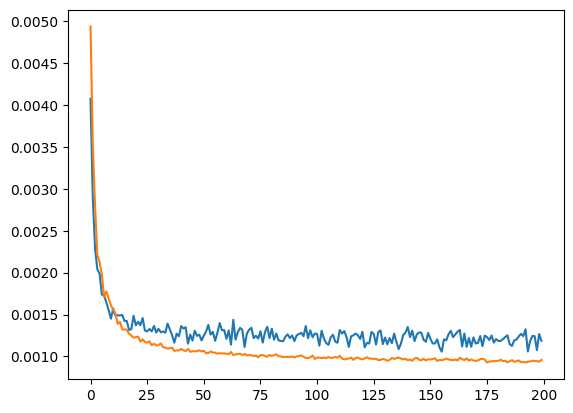

In [7]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])


In [8]:
model.load_state_dict(best_weights)

<All keys matched successfully>

/tmp/ipykernel_460484/2368876381.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t1 = torch.tensor(LR.view(1,1,64,64))


Text(0.5, 1.0, 'Train_Ground truth')

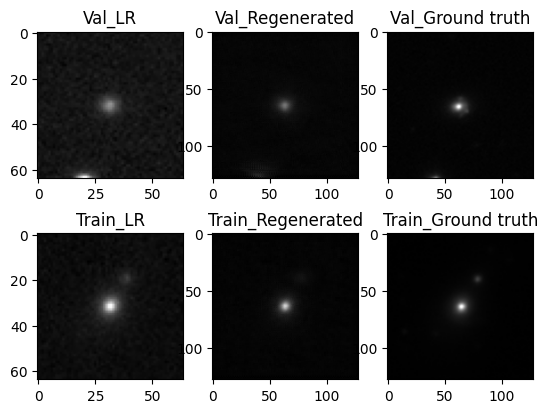

In [9]:
pre, post, tHR = show_random_image(val_dataset, model, 30)
pret, postt, tHRt = show_random_image(train_dataset, model, 270)
plot, axes = plt.subplots(2,3)
axes[0][0].imshow(pre)
axes[0][1].imshow(post)
axes[0][2].imshow(tHR)
axes[0][0].set_title("Val_LR")
axes[0][1].set_title("Val_Regenerated")
axes[0][2].set_title("Val_Ground truth")

axes[1][0].imshow(pret)
axes[1][1].imshow(postt)
axes[1][2].imshow(tHRt)
axes[1][0].set_title("Train_LR")
axes[1][1].set_title("Train_Regenerated")
axes[1][2].set_title("Train_Ground truth")

In [10]:
torch.save(best_weights, '../trained_weights/ResnetSISR_sparse_DA.pt')